# Exercise 07 RNN & LSTM - Assignment

<span style="color:red">**The submission deadline of this assignment is 23/04/2024 23:59.**</span>

<span style="color:red">**Do not submit the saved `.pth` file of the trained CNN, because the file size is too big.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a text-classifier using LSTM.

The problem to be solved is to predict the class of a product based on the product page (title and description) on the E-commerce platform:

|Class|Example product page|
|-|-|
|Books|Inner Engineering: A Yogi's Guide to Joy About the Author Sadhguru Jaggi VasudevSADHGURU is a yogi, mystic, and visionary who established the Isha Foundation, a nonprofit dedicated to the cultivation of human potential...|
|Clothing & Accessories|Amour Butterfly Design Sunglasses For Girls 6+ Years { SKU16 } Amour Butterfly Design Sunglasses to give full protection. Very light weight. Highly durable. Its safe for kids eyes and give full eye protection against harmful uv rays...|
|Electronics|Bluetooth Dongle USB CSR 4.0 Adapter Receiver Transfer Wireless Adapter for PC Computer Laptop Supports Windows 10 8.1 8 7 Vista XP - Upgraded Version...|
|Household|Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch...|

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a LSTM-based text classifier
- Train the network, save and reload the best one
- Test and evaluation
- Make predictions on unseen text (defined by yourself)

## Import libraries

In [19]:
# [TBC] complete your code here with proper comments
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import classification_report

from torch import nn

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

from torchtext.data.utils import get_tokenizer # for tokenization
from torchtext.vocab import build_vocab_from_iterator # for creating vocabulary

In [20]:
# suppress all warnings
warnings.filterwarnings("ignore")

## Task 1. Build the data pipeline

You are required to use `ecommerce_dataset.csv` which can be downloaded from the Learn Platform.

<span style="color:red">**[TBC]**</span> You need to:
- Load the dataset from the `ecommerce_dataset.csv` file
- Tokenization
- Create the vocabulary
- Cut/Pad each news articles to the same sequence length
- Create the tensor dataset and dataloader for the training, validation, and test set

In [21]:
# [TBC] complete your code here with proper comments
df = pd.read_csv('C:\\Users\\thiba\\Downloads\\ecommerce_dataset.csv')
classes = ['Books', 'Clothing & Accessories', 'Electronics', 'Household']
df

,text,label
0,Paper Plane Design Framed Wall Hanging Motivat...,3
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",3
2,SAF 'UV Textured Modern Art Print Framed' Pain...,3
3,"SAF Flower Print Framed Painting (Synthetic, 1...",3
4,Incredible Gifts India Wooden Happy Birthday U...,3
...,...,...
50419,Strontium MicroSD Class 10 8GB Memory Card (Bl...,2
50420,CrossBeats Wave Waterproof Bluetooth Wireless ...,2
50421,Karbonn Titanium Wind W4 (White) Karbonn Titan...,2
50422,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",2


In [22]:
# get the tokenizer
tokenizer = get_tokenizer('basic_english')

# define an intertor function to perform tokenization
def yield_tokens(df, tokenizer):
    for i in range(len(df)):
        yield tokenizer(df['text'].values[i])

# create the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(df, tokenizer), specials = ['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [23]:
# print the number of unique tokens in the vocabulary
print('The number of unique tokens in the vocabulary:', len(vocab))

The number of unique tokens in the vocabulary: 110481


In [24]:
# cut/pad all news articles to the same sequence length
seq_length = 20 # number of tokens in the sequence for each news articles
X = []
for i in range(len(df)):
    text = df['text'].values[i]
    text = vocab(tokenizer(text))
    if len(text) < seq_length:
        text = text + [0] * (seq_length - len(text)) # pad the sequence with 0
    else:
        text = text[:seq_length] # cut the sequence to the pre-defined length
    X.append(text)
X = np.array(X)
print('The shape of input:', X.shape)
y = df['label'].values
print('The shape of label:', y.shape)

The shape of input: (50424, 20)
The shape of label: (50424,)


In [25]:
# create the tensor dataset
ds = TensorDataset(
    torch.tensor(X, dtype = torch.int64),
    torch.tensor(y, dtype = torch.int64)
)

In [26]:
# split the dataset into the training, validation, and test set
train_val_ds, test_ds = random_split(ds, [0.7, 0.3])
train_ds, val_ds = random_split(ds, [0.8, 0.2])

In [28]:
# create the training, validation, and test data loaders
batch_size = 512 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

In [29]:
# get one batch and print its shape
for batch in train_dl:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([512, 20])
torch.Size([512])


## Task 2. Create a CNN-based image classifier

<span style="color:red">**[TBC]**</span> You need to:
- Define a custom class to specify the structure and the forward method of the network
    - You are required to use `nn.LSTM()` layer in the network
- Specify the device used for computation
- Create an instance of the network and move it to the corresponding device

In [30]:
# [TBC] complete your code here with proper comments
# define a custom neural network class
class LSTMClassifier(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_class):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, x):
        x = self.embedding(x)
        out, (h, c) = self.lstm(x)
        return self.fc(h[-1])

In [31]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [32]:
# create the neural network
num_embeddings = len(vocab) # number of unique tokens in the vocabulary
embedding_dim = 64
hidden_size = 32
num_class = 4
model = LSTMClassifier(num_embeddings, embedding_dim, hidden_size, num_class).to(device)

## Task 3. Train the network, save and reload the best one

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function
    - <span style="color:red">**Do not submit the saved file as it will be too big.**</span>
- Train the network
- Reload the best model after training
- Plot the loss history of the training process

In [33]:
# [TBC] complete your code here with proper comments
# define the training function
def train(train_dl, val_dl, model, loss_fn, optimizer, epochs, early_stopping_patience, lr_scheduler):
    # initialization
    min_val_loss, patience_counter = np.inf, 0
    saved_path, start_time = '', datetime.datetime.now()
    histories = {'train_batch': [], 'train_epoch': [], 'val_batch': [], 'val_epoch': []}

    for epoch in range(epochs):
        # train
        model.train()
        train_epoch_loss = 0.0
        for X, y in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            train_batch_loss = loss_fn(model(X), y)
            train_batch_loss.backward()
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
            histories['train_batch'].append(train_batch_loss.item())
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for X, y in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y = X.to(device), y.to(device)
                val_batch_loss = loss_fn(model(X), y)
                val_epoch_loss += val_batch_loss.item()
                histories['val_batch'].append(val_batch_loss.item())
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        if current_lr != optimizer.param_groups[0]['lr']:
            print(f'Learning rate reduced after epoch {epoch+1}')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss, patience_counter = val_epoch_loss, 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = end_time.strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = f'epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping!')
                break
                
    return histories, saved_path

In [36]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 50
early_stopping_patience = 10
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5
)

In [37]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler
)
# reload the best model
model.load_state_dict(torch.load(saved_path))

Validation batch: 100%|██████████| 20/20 [00:00<00:00, 43.34it/s]


Epoch 1: train loss = 1.294063, val loss = 1.281961, time consumed = 0:00:09
Model saved after epoch 1


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 43.34it/s]


Epoch 2: train loss = 1.284409, val loss = 1.272395, time consumed = 0:00:18
Model saved after epoch 2


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 41.87it/s]


Epoch 3: train loss = 1.274426, val loss = 1.261612, time consumed = 0:00:27
Model saved after epoch 3


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 34.22it/s]


Epoch 4: train loss = 1.262205, val loss = 1.250067, time consumed = 0:00:36
Model saved after epoch 4


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 48.05it/s]


Epoch 5: train loss = 1.247522, val loss = 1.243367, time consumed = 0:00:46
Model saved after epoch 5


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 44.92it/s]


Epoch 6: train loss = 1.229237, val loss = 1.208298, time consumed = 0:00:55
Model saved after epoch 6


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 48.64it/s]


Epoch 7: train loss = 1.192124, val loss = 1.152392, time consumed = 0:01:04
Model saved after epoch 7


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 45.02it/s]


Epoch 8: train loss = 1.085107, val loss = 1.030728, time consumed = 0:01:14
Model saved after epoch 8


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 40.43it/s]


Epoch 9: train loss = 0.994847, val loss = 0.985986, time consumed = 0:01:23
Model saved after epoch 9


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 31.53it/s]


Epoch 10: train loss = 0.958495, val loss = 0.949012, time consumed = 0:01:33
Model saved after epoch 10


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 41.97it/s]


Epoch 11: train loss = 0.922260, val loss = 0.949238, time consumed = 0:01:41


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 43.42it/s]


Epoch 12: train loss = 0.880796, val loss = 0.866213, time consumed = 0:01:50
Model saved after epoch 12


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 39.31it/s]


Epoch 13: train loss = 0.809300, val loss = 0.816887, time consumed = 0:01:59
Model saved after epoch 13


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 47.92it/s]


Epoch 14: train loss = 0.740258, val loss = 0.708802, time consumed = 0:02:08
Model saved after epoch 14


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 42.01it/s]


Epoch 15: train loss = 0.663546, val loss = 0.657404, time consumed = 0:02:17
Model saved after epoch 15


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 39.58it/s]


Epoch 16: train loss = 0.609950, val loss = 0.608773, time consumed = 0:02:26
Model saved after epoch 16


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 40.39it/s]


Epoch 17: train loss = 0.564365, val loss = 0.582890, time consumed = 0:02:35
Model saved after epoch 17


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 46.19it/s]


Epoch 18: train loss = 0.520771, val loss = 0.505929, time consumed = 0:02:45
Model saved after epoch 18


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 38.80it/s]


Epoch 19: train loss = 0.468134, val loss = 0.459582, time consumed = 0:02:54
Model saved after epoch 19


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 45.93it/s]


Epoch 20: train loss = 0.425911, val loss = 0.448430, time consumed = 0:03:03
Model saved after epoch 20


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 44.92it/s]


Epoch 21: train loss = 0.403456, val loss = 0.432963, time consumed = 0:03:12
Model saved after epoch 21


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 40.63it/s]


Epoch 22: train loss = 0.365207, val loss = 0.401611, time consumed = 0:03:22
Model saved after epoch 22


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 40.70it/s]


Epoch 23: train loss = 0.353049, val loss = 0.411533, time consumed = 0:03:31


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 39.44it/s]


Epoch 24: train loss = 0.326008, val loss = 0.375191, time consumed = 0:03:43
Model saved after epoch 24


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 47.08it/s]


Epoch 25: train loss = 0.310641, val loss = 0.361623, time consumed = 0:03:52
Model saved after epoch 25


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 42.02it/s]


Epoch 26: train loss = 0.299164, val loss = 0.334447, time consumed = 0:04:01
Model saved after epoch 26


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 42.81it/s]


Epoch 27: train loss = 0.281420, val loss = 0.330572, time consumed = 0:04:10
Model saved after epoch 27


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 38.79it/s]


Epoch 28: train loss = 0.274444, val loss = 0.316198, time consumed = 0:04:19
Model saved after epoch 28


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 39.11it/s]


Epoch 29: train loss = 0.256785, val loss = 0.324417, time consumed = 0:04:28


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 48.56it/s]


Epoch 30: train loss = 0.260850, val loss = 0.307023, time consumed = 0:04:37
Model saved after epoch 30


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 47.42it/s]


Epoch 31: train loss = 0.238274, val loss = 0.307900, time consumed = 0:04:47


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 32.78it/s]


Epoch 32: train loss = 0.230352, val loss = 0.296307, time consumed = 0:04:56
Model saved after epoch 32


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 47.49it/s]


Epoch 33: train loss = 0.228560, val loss = 0.311239, time consumed = 0:05:05


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 37.72it/s]


Epoch 34: train loss = 0.213590, val loss = 0.285105, time consumed = 0:05:14
Model saved after epoch 34


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 45.51it/s]


Epoch 35: train loss = 0.209356, val loss = 0.306642, time consumed = 0:05:23


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 36.45it/s]


Epoch 36: train loss = 0.197669, val loss = 0.278138, time consumed = 0:05:34
Model saved after epoch 36


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 49.08it/s]


Epoch 37: train loss = 0.198340, val loss = 0.277699, time consumed = 0:05:43
Model saved after epoch 37


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 42.86it/s]


Epoch 38: train loss = 0.191863, val loss = 0.277793, time consumed = 0:05:52


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 47.63it/s]


Epoch 39: train loss = 0.189151, val loss = 0.275963, time consumed = 0:06:01
Model saved after epoch 39


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 44.86it/s]


Epoch 40: train loss = 0.179664, val loss = 0.282374, time consumed = 0:06:13


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 43.12it/s]


Epoch 41: train loss = 0.174905, val loss = 0.267356, time consumed = 0:06:22
Model saved after epoch 41


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 35.15it/s]


Epoch 42: train loss = 0.172408, val loss = 0.295009, time consumed = 0:06:33


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 43.42it/s]


Epoch 43: train loss = 0.184942, val loss = 0.265353, time consumed = 0:06:43
Model saved after epoch 43


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 37.75it/s]


Epoch 44: train loss = 0.163975, val loss = 0.252509, time consumed = 0:06:54
Model saved after epoch 44


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 43.35it/s]


Epoch 45: train loss = 0.157040, val loss = 0.253982, time consumed = 0:07:03


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 43.43it/s]


Epoch 46: train loss = 0.158661, val loss = 0.249081, time consumed = 0:07:12
Model saved after epoch 46


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 39.94it/s]


Epoch 47: train loss = 0.149445, val loss = 0.254926, time consumed = 0:07:21


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 43.50it/s]


Epoch 48: train loss = 0.144826, val loss = 0.259017, time consumed = 0:07:29


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 37.67it/s]


Epoch 49: train loss = 0.151560, val loss = 0.252640, time consumed = 0:07:39


Validation batch: 100%|██████████| 20/20 [00:00<00:00, 42.26it/s]


Epoch 50: train loss = 0.137729, val loss = 0.245318, time consumed = 0:07:47
Model saved after epoch 50


<All keys matched successfully>

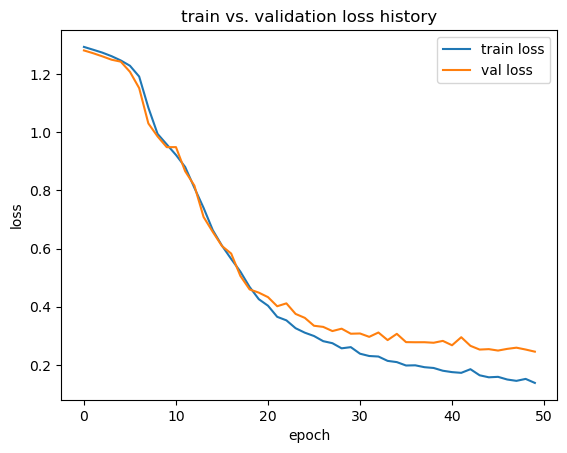

In [38]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Task 4. Test and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [39]:
# [TBC] complete your code here with proper comments
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device) # move data to GPU
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [40]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, model, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())
    
print(classification_report(test_label, test_pred, target_names = classes))

test loss = 0.15370837822556496
                        precision    recall  f1-score   support

                 Books       0.97      0.95      0.96      3594
Clothing & Accessories       0.98      0.97      0.97      2625
           Electronics       0.95      0.95      0.95      3079
             Household       0.96      0.97      0.96      5829

              accuracy                           0.96     15127
             macro avg       0.96      0.96      0.96     15127
          weighted avg       0.96      0.96      0.96     15127



## Task 5. Make predictions on unseen text

<span style="color:red">**[TBC]**</span> You need to:
- Specify an unseen product page by yourself
    - Use a real product page on the ecommerce platform as Amazon
    - Or make up a fake one yourself
- Define a `predict()` function for making predictions
- Use the `predict()` function to classify the product page into one of the pre-defined classes

In [44]:
# [TBC] complete your code here with proper comments
# specify an unseen news article
unseen_product = 'Xiaomi Redmi Note 13 5G offers Performance, Power up your daily essentials, Ultra-clear 200MP camera with OIS and ultimate hardware for flawless imaging, Immersive andsmooth display for gaming, 67W Turbo Charge with 5100mAh battery, Cutting-edge immersive visuals'
print(unseen_product)

Xiaomi Redmi Note 13 5G offers Performance, Power up your daily essentials, Ultra-clear 200MP camera with OIS and ultimate hardware for flawless imaging, Immersive andsmooth display for gaming, 67W Turbo Charge with 5100mAh battery, Cutting-edge immersive visuals


In [45]:
# define a predict function to make prediction on unseen text
def predict(model, text):
    X = vocab(tokenizer(text))
    if len(X) < seq_length:
        X = X + [0] * (seq_length - len(X))
    else:
        X = X[:seq_length]
    X = np.array(X).reshape(1, -1) # add the batch dimension, batch_size = 1
    X = torch.tensor(X, dtype = torch.int64)
    logit = model(X.to(device))
    _, pred = torch.max(logit, 1)
    return pred.item()

In [46]:
print('The predicted class is:', classes[predict(model, unseen_news)])

The predicted calss is: Electronics
